(sec:ir-tutorial)=
# IR spectroscopy

The infrared (IR) absorption process involves the absorption of light with low photon energy (from approx. 800 nm to approx. 1000 $\mu$m) which promotes the excitation of molecular vibrations. Of the entire IR photon energy range, the photons which excite fundamental vibrations of covalent bonds have energies in the range 2.5-25 $\mu$m {cite}`Norman2018, Centrone2015`. The absorbed photon energies (i.e., IR absorption peak positions) correspond to the molecular vibrational frequencies, while the IR intensities are related to the IR linear absorption cross-section {cite}`Norman2018`

$$
\sigma_k(\omega)= \frac{\pi}{3\epsilon_0c}\left(\frac{\partial \mu}{\partial Q_k}\right)^2\frac{\gamma_{k}}{(\omega_{k0}-\omega)^2+\gamma_{k}^2}\,
$$

Here, $\mu$ is the molecular dipole moment of the electronic ground state, $Q_k$ is the normal coordinate corresponding to the vibrational mode $k$, $\omega$ is the angular frequency of the absorbed electromagnetic radiation, $\omega_{k0}$ is the angular frequency difference between the excited vibrational state $|k\rangle$ and the ground state, and $\gamma_{k}$ is the half-width broadening associated with the inverse lifetime of $|k\rangle$. As can be seen from the equation, the IR absorption cross-section depends on the derivative of the dipole moment with respect to the normal coordinate $Q_k$. This means that the only modes which have non-zero IR absorption cross-sections are those associated with a change in the dipole moment {cite}`Siebert2007`.

These molecular vibrations constitute fingerprints of different functional groups present in the system and thus are important for chemical characterization and molecular identification.

The first step in an IR spectrum calculation is to determine the normal modes and frequencies. These are obtained from the eigenstates and eigenvalues of the Hessian matrix which collects all the second order derivatives of the energy $E$ with respect to the nuclear coordinates. For the ground state, the Hessian can be determined [analytically](sec:mol-hessian), or numerically based on the analytical gradient. The [dipole moment gradient](dipole_mom_gradient:label), required to compute IR absorption cross-sections, can also be determined analytically. 

In [3]:
import veloxchem as vlx
import numpy as np
import sys
import py3Dmol as p3d
from veloxchem.veloxchemlib import bohr_in_angstroms

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 4.


In [4]:
# Define the molecule and basis set
molecule_string = """3

  O 0.000 0.000  0.000
  H 0.000 0.000  0.950
  H 0.896 0.000 -0.317"""
basis_set_label = 'sto-3g'

molecule = vlx.Molecule.from_xyz_string(molecule_string)
basis = vlx.MolecularBasis.read(molecule, basis_set_label)

* Info * Reading basis set from file: /home/thomas/Notebook/anaconda/envs/echem/lib/python3.10/site-packages/veloxchem/basis/STO-3G
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                               Basis: STO-3G                                                                              
                                                                                                                          
                               Atom Contracted GTOs           Primitive GTOs                                              
                                                                                                                          
       

In [7]:
view = p3d.view(linked=True, viewergrid=(1,1),width=300,height=200)
view.addModel(molecule_string, 'xyz', viewer=(0,0))
view.setViewStyle({"style": "outline", "width": 0.05})
view.setStyle({"stick":{},"sphere": {"scale":0.25}})
view.rotate(-90, "x")
view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [25]:
# Run the SCF calculation
scf_settings = {}
method_settings = {} #{'xcfun':'b3lyp'}
scf_drv = vlx.ScfRestrictedDriver()
scf_drv.update_settings(scf_settings, method_settings)
scf_results = scf_drv.compute(molecule, basis)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Hartree-Fock                                         
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

Now we can calculate the Hessian 

In [29]:
# Create the Hessian Driver and use it to compute an analytical SCF Hessian
hessian_settings = {}
hessian_drv = vlx.scfhessiandriver.ScfHessianDriver(scf_drv)
hessian_drv.update_settings(method_settings, hessian_settings)
hessian_drv.compute(molecule, basis)

                                                                                                                          
                                                    SCF Hessian Driver                                                    
                                                                                                                          
                                   *** Time spent in Hessian calculation: 22.63 sec ***                                   
                                                                                                                          
                                                                                                                          


In [16]:
hessian_drv.print_hessian(molecule)

                                           Numerical Hessian (Hartree/Bohr**2)                                            
                                          -------------------------------------                                           
                                                                                                                          
  Coord.       1 O(x)          1 O(y)          1 O(z)          2 H(x)          2 H(y)          2 H(z)          
                                                                                                                          
  1 O(x)       0.77341782     -0.00000038     -0.22069612     -0.05793218      0.00000009      0.05915262
  1 O(y)      -0.00000038     -0.08462376     -0.00000043      0.00000000      0.04250776     -0.00000043
  1 O(z)      -0.22069612     -0.00000043      0.93182669     -0.07097807     -0.00000044     -0.79549528
  2 H(x)      -0.05793218      0.00000000     -0.07097807      0.05352700     

The normal modes and frequencies are then determined by diagonalizing the Hessian. First, the translation and rotational modes must be projected out, leaving $3N-6$ (or $3N-5$ for a linear molecule) vibrational modes for a system with $N$ atoms. This is done under the hood with the help of [geomeTRIC](sec:geometric). 

The IR intensities are determined as discussed in more detail [here](dipole_mom_gradient:label).

In [17]:
hessian_drv.vibrational_analysis(molecule)

                                                   Vibrational Analysis                                                   
                                                                                                                          
                 Harmonic frequencies (in cm**-1), force constants (in mdyne/A), reduced masses (in amu),                 
                                                IR intensities (in km/mol),                                               
                                         and Cartesian normal mode displacements.                                         
                                                                                                                          
                                                                                                                          
  Index:                        1                              2                              3               
  Frequency:                

In [18]:
def add_broadening(list_ex_energy, list_osci_strength, line_profile='Lorentzian', line_param=10, step=10):
        x_min = np.amin(list_ex_energy) - 50
        x_max = np.amax(list_ex_energy) + 50
        x = np.arange(x_min, x_max, step)
        y = np.zeros((len(x)))

        # go through the frames and calculate the spectrum for each frame
        for xp in range(len(x)):
            for e, f in zip(list_ex_energy, list_osci_strength):
                if line_profile == 'Gaussian':
                    y[xp] += f * np.exp(-(
                        (e - x[xp]) / line_param)**2)
                elif line_profile == 'Lorentzian':
                    y[xp] += 0.5 * line_param * f / (np.pi * (
                        (x[xp] - e)**2 + 0.25 * line_param**2))
        return x, y

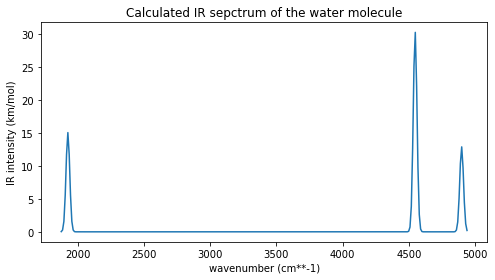

In [19]:
# plot the IR spectrum
from matplotlib import pyplot as plt

plt.figure(figsize=(7,4))
x1,y1 = hessian_drv.frequencies, hessian_drv.ir_intensities
x1i, y1i = add_broadening(x1,y1,line_profile='Gaussian',line_param=20,step=10)
plt.plot(x1i,y1i)
plt.xlabel('wavenumber (cm**-1)')
plt.ylabel('IR intensity (km/mol)')
plt.title("Calculated IR sepctrum of the water molecule")
plt.tight_layout(); plt.show()

![Experimental spectrum](../../img/ir_raman/ir-exp-water.png)

Let's now visualize the three vibrational normal modes. The two high frequency modes are OH stretching modes (one symmetryc and one asymmetric), while the lower energy mode is a bond angle bending.

In [20]:
# To animate the normal mode we will need both the geometry and the displacements 
def get_normal_mode(molecule, normal_mode):
    elements = molecule.get_labels()
    # Transform from au to A
    coords = molecule.get_coordinates() * bohr_in_angstroms()
    natm = molecule.number_of_atoms()
    
    vib_xyz = "%d\n\n" % natm
    nm = normal_mode.reshape(natm, 3)
    for i in range(natm):
        # add coordinates:
        vib_xyz += elements[i] + " %15.7f %15.7f %15.7f " % (coords[i,0], coords[i,1], coords[i,2])
        # add displacements:
        vib_xyz += "%15.7f %15.7f %15.7f\n" % (nm[i,0], nm[i,1], nm[i,2])
    return vib_xyz

In [21]:
vib_1 = get_normal_mode(molecule, hessian_drv.normal_modes[0])
vib_2 = get_normal_mode(molecule, hessian_drv.normal_modes[1])
vib_3 = get_normal_mode(molecule, hessian_drv.normal_modes[2])

In [22]:
print("This is the bending mode at 1927.09 cm-1.")
view = p3d.view(width=300, height=300)
view.addModel(vib_1, "xyz", {'vibrate': {'frames':10,'amplitude':0.75}})
view.setViewStyle({"style": "outline", "width": 0.05})
view.setStyle({"stick":{},"sphere": {"scale":0.25}})
view.animate({'loop': 'backAndForth'})
view.rotate(-90, "x")
view.zoomTo()
view.show()

This is the bending mode at 1927.09 cm-1.


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [23]:
print("This is the symmetric stretching mode at 4545.78 cm-1.")
view = p3d.view(width=300, height=300)
view.addModel(vib_2, "xyz", {'vibrate': {'frames':10,'amplitude':0.75}})
view.setViewStyle({"style": "outline", "width": 0.05})
view.setStyle({"stick":{},"sphere": {"scale":0.25}})
view.animate({'loop': 'backAndForth'})
view.rotate(-90, "x")
view.zoomTo()
view.show()

This is the symmetric stretching mode at 4545.78 cm-1.


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [24]:
print("This is the asymmetric stretching mode at 4896.44 cm-1.")
view = p3d.view(width=300, height=300)
view.addModel(vib_3, "xyz", {'vibrate': {'frames':10,'amplitude':0.75}})
view.setViewStyle({"style": "outline", "width": 0.05})
view.setStyle({"stick":{},"sphere": {"scale":0.25}})
view.animate({'loop': 'backAndForth'})
view.rotate(-90, "x")
view.zoomTo()
view.show()

This is the asymmetric stretching mode at 4896.44 cm-1.


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol